In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import subprocess
import os
%matplotlib inline

In [58]:
# Exploring all NVDI data that I have
data_folder = '/Users/Chiao/google-drive/projects/Galvanize/fall-foliage-finder/data/nvdi/nc/'
files = os.listdir(data_folder)

In [107]:
print 'Number of files =', len(files)
print 'Example file name:', files[0]
print 'Shape of all latitudes', lats.shape
print 'Shape of all longitudes', lons.shape
print 'Sahep of NVDI variable', var.shape

Number of files = 449
Example file name: 2002.01.01.mask.nc
Shape of all latitudes (614,)
Shape of all longitudes (927,)
Sahep of NVDI variable (614, 927)


In [81]:
nc = Dataset(data_folder+files[0], 'r')
lats = nc.variables['lat'][:]
lons = nc.variables['lon'][:]
nc.close()

data = np.zeros([len(lats), len(lons), len(files)])
for i, f in enumerate(files):
    nc = Dataset(data_folder+f, 'r')
    var = nc.variables['Band1'][:]
    data[:,:,i] = var
    nc.close()

In [82]:
data.shape

(614, 927, 449)

In [83]:
# Constructing a mask where True == somewhere in the time series there's a NaN value
is_nan = (data == -3000.)
mask = np.any(is_nan, axis=2)
mask.shape

(614, 927)

In [84]:
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [126]:
def plot_time_series(i, j, time_series):
    fig = plt.figure(figsize=(20,6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(np.arange(len(time_series)), time_series)
    note = 'lat = {0}, lon = {1}'.format(lats[i], lons[j])
    ax.text(0.9, 2, note, fontsize=20)
    plt.show()

In [133]:
#plt.figure(figsize=(20,12))
# for i in np.arange(450, 460):
#     for j in np.arange(798, 800):
#         if not mask[i, j]:
#             time_series = data[i, j, :]
#             plot_time_series(i, j, time_series)
            

In [32]:
# Set default font size for matplotlib plots
mpl.rcParams.update({'font.size': 16})
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=12)

In [85]:
def plot_map(lons, lats, data, cmap=mpl.cm.get_cmap('BuGn')):
    cmap = cmap
    norm = mpl.colors.Normalize(data.min, data.max)
    area_thresh=25000
    land_color='grey'
    ocean_color='lightblue'

    fig = plt.figure(figsize=(20,12))

    ax = fig.add_subplot(1,1,1)
    m = Basemap(projection='cyl', llcrnrlat=lats.min(), llcrnrlon=lons.min(),
            urcrnrlat=lats.max(), urcrnrlon=lons.max(), resolution='h',
            area_thresh=area_thresh)
    #xi, yi = m(lons, lats)
    #xi, yi = np.meshgrid(xi, yi)
    #m.pcolormesh(lons, lats, var, cmap=cmap, norm=norm)
    m.scatter(lons, lats, var, cmap=cmap, norm=norm)
    m.drawlsmask(land_color=land_color, ocean_color=ocean_color, lakes=True)
    m.drawcountries()
    m.drawcoastlines()


In [115]:
%%writefile clustering.py

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from netCDF4 import Dataset
import numpy as np
import pandas as pd

class Location_Clusterer(KMeans):
    def __init__(self, n_clusters=8):
        KMeans.__init__(self, n_clusters=n_clusters)
        self.source_files = []
        self.coords = None
        self.coords2d = None
        self.mask = None
        self.raw_data = None
        self.data2d = None

    def read_data(self, file_name, var_name):
        '''
        Read data from netCDF input file (1 file 1 variable at a time)
        
        Parameters
        -----------
        file_name: string, path to input file
        var_name: string, name of variable as appeared in the netCDF file
        '''
        
        # Initialize the coordinate system and dimension if this is the first file read
        if len(self.source_files) == 0:
            nc = Dataset(file_name, 'r')
            self.source_files.append((file_name, var_name))
            
            lats = nc.variables['lat'][:]
            lons = nc.variables['lon'][:]
            self.coords = np.meshgrid(lons, lats)          
        
        # Reading the actual data
        nc = Dataset(file_name, 'r')
        var = nc.variables[var_name][:]
        if len(var.shape) < 3:
            var = var[np.newaxis]
        # Check dimensions of the new input data against existing data
        if var.shape[-2:] != self.coords[0].shape:
            raise InputError('Dimensions of input data do not match existing data.')
        # Initialize self.raw_data if it is previously empty
        elif self.raw_data is None:
            self.raw_data = np.copy(var)
        # Adding data if there's already some data stored
        else:
            self.raw_data = np.append(self.raw_data, var, axis=0)
        
        # Check the mask from this file and initialize or update current mask 
        if len(var.mask.shape) == 3:
            mask = var.mask[0][np.newaxis]
        else:
            mask = var.mask[np.newaxis]
            
        if self.mask is None:
            self.mask = np.copy(mask)
        else:
            self.mask = np.append(self.mask, mask, axis=0)
            self.mask = np.any(self.mask, axis=0)[np.newaxis]
            
    def transform_data(self):
        inmask = self.mask.flatten().shape[0] - sum(self.mask.flatten())
        flatten_mask = (1-self.mask.flatten()).astype(bool)
        
        self.coords2d = np.zeros((inmask, len(self.coords)))
        for i in xrange(len(self.coords)):
            self.coords2d[:, i] = self.coords[i].flatten()[flatten_mask]
        
        self.data2d = np.zeros((inmask, self.raw_data.shape[0]))
        for i in xrange(self.raw_data.shape[0]):
            temp = self.raw_data[i].flatten().data
            self.data2d[:, i] = temp[flatten_mask]
        
            
#     def fit(self):
#         """Compute k-means clustering from the 2D data stored in the object.
            
#         """
#         random_state = check_random_state(self.random_state)
#         X = self.data2d
#         X = self._check_fit_data(X)

#         self.cluster_centers_, self.labels_, self.inertia_, self.n_iter_ = \
#             k_means(
#                 X, n_clusters=self.n_clusters, init=self.init,
#                 n_init=self.n_init, max_iter=self.max_iter,
#                 verbose=self.verbose, return_n_iter=True,
#                 precompute_distances=self.precompute_distances,
#                 tol=self.tol, random_state=random_state, copy_x=self.copy_x,
#                 n_jobs=self.n_jobs)
#         return self
            

        
        
            
        

Overwriting clustering.py


In [116]:
from clustering import Location_Clusterer

folder = '/Users/Chiao/google-drive/projects/Galvanize/fall-foliage-finder/data/'
files = ['veg.nc', 'normals/ppt.monthly.mask.nc', 'normals/tmean.monthly.mask.nc', 'elev.nc']
var_names = ['Cv', 'Band1', 'Band1', 'elev']

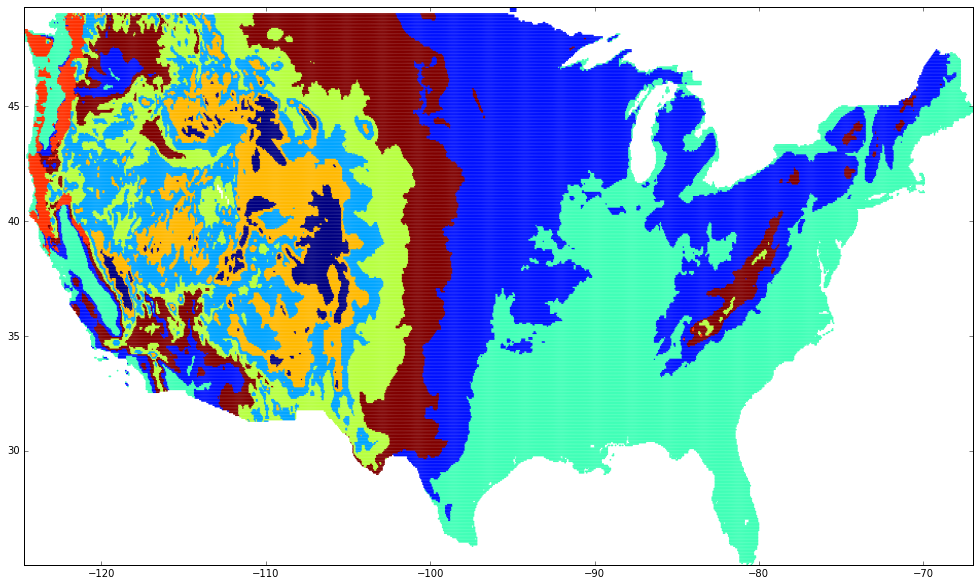

In [111]:
def plot_list_in_2D(x, y, val):
    plt.figure(figsize=(17,10))
    plt.scatter(x, y, c=val, edgecolors='none', s=3)
    plt.xlim(x.min(), x.max())
    plt.ylim(y.min(), y.max())
    plt.show()

(36, 614, 927)
(1, 614, 927)


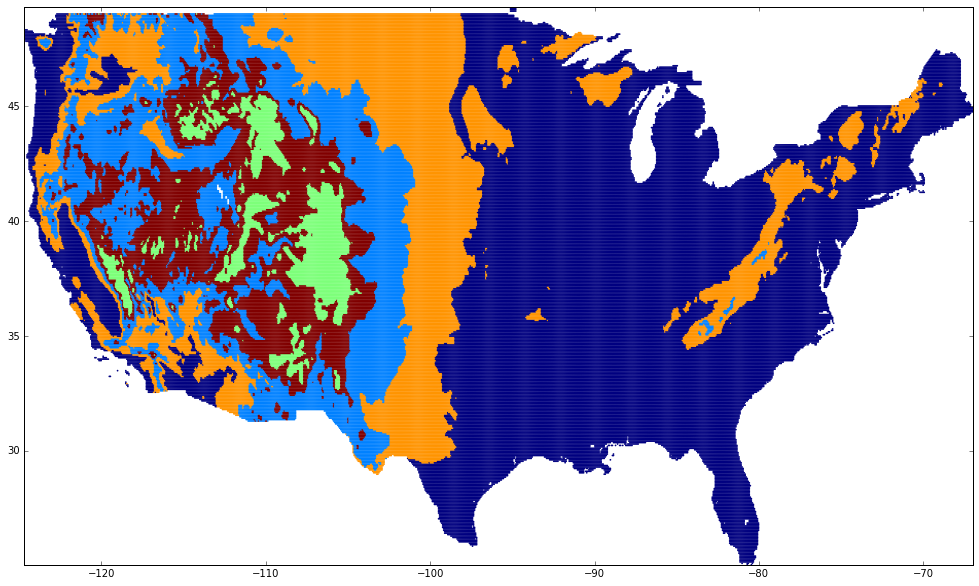

(36, 614, 927)
(1, 614, 927)


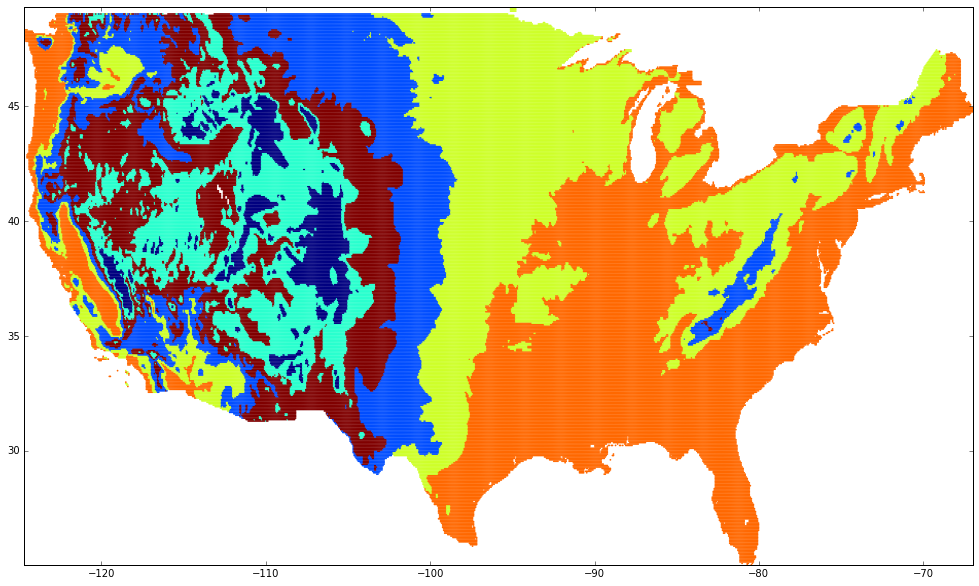

(36, 614, 927)
(1, 614, 927)


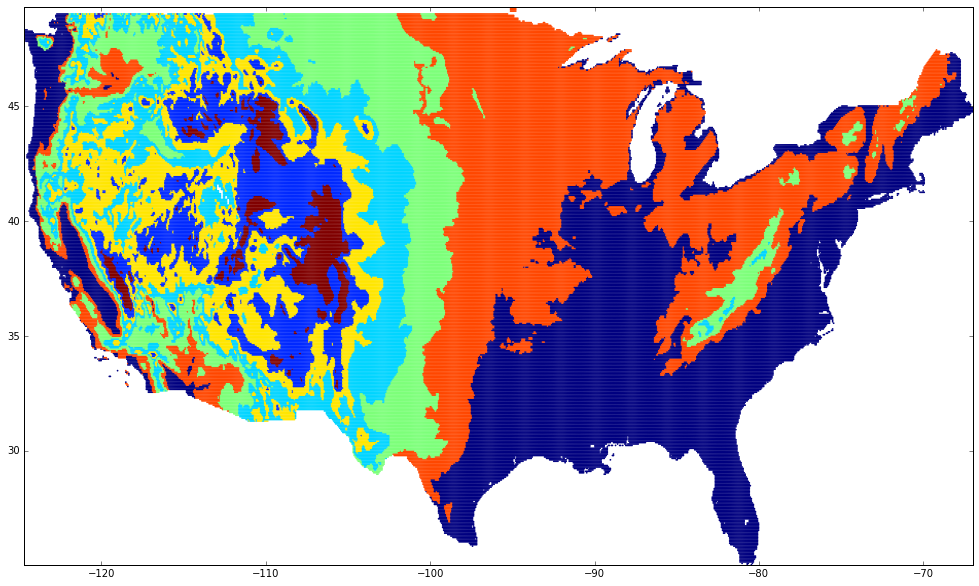

(36, 614, 927)
(1, 614, 927)


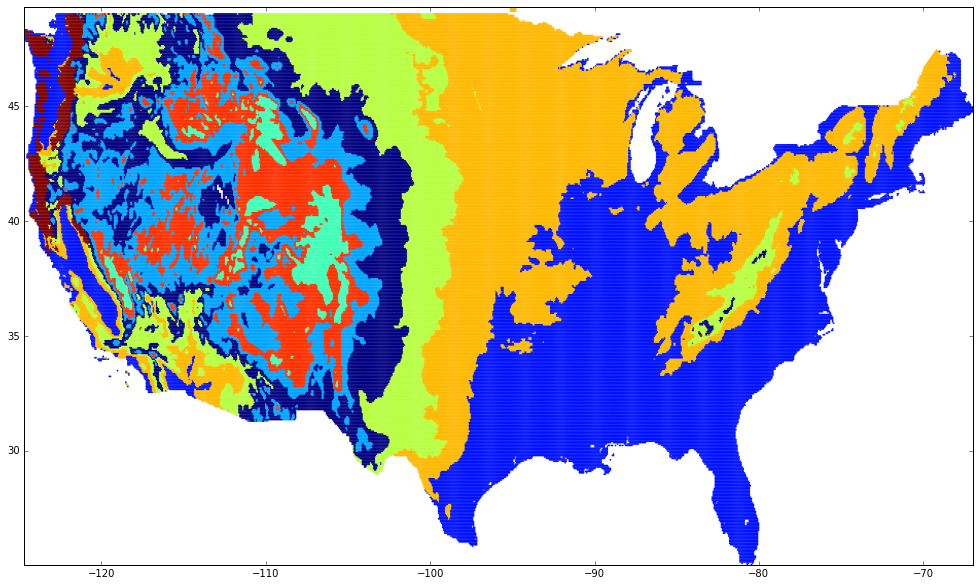

(36, 614, 927)
(1, 614, 927)


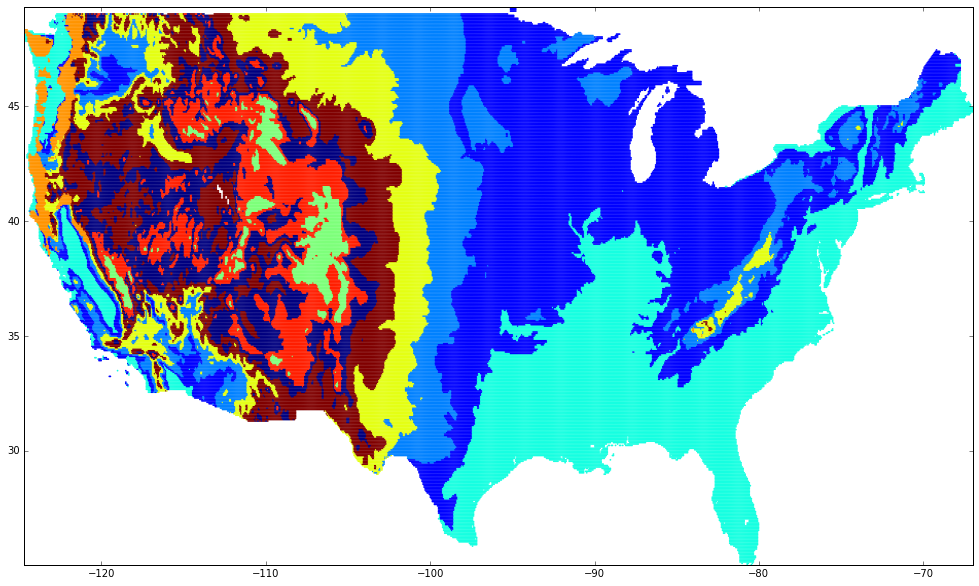

(36, 614, 927)
(1, 614, 927)


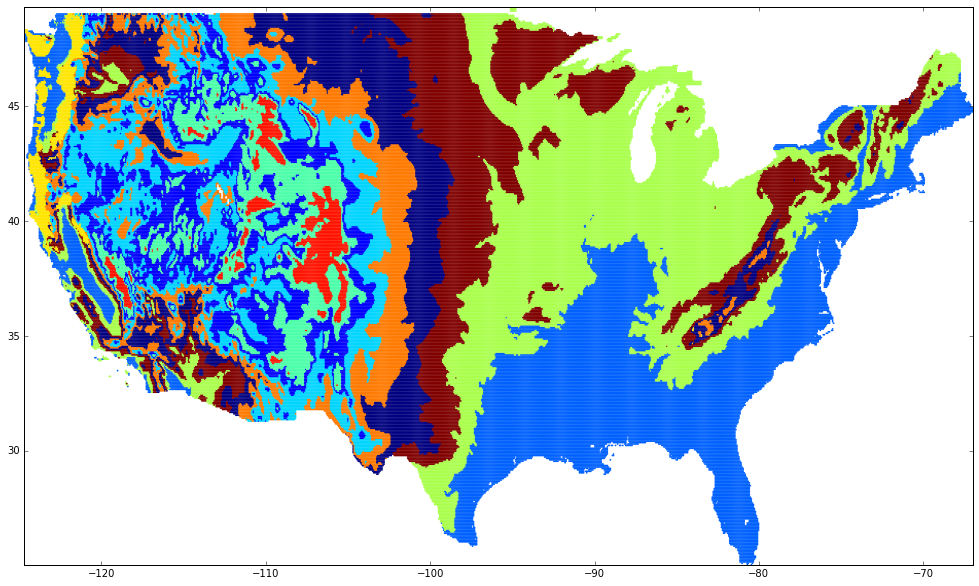

(36, 614, 927)
(1, 614, 927)


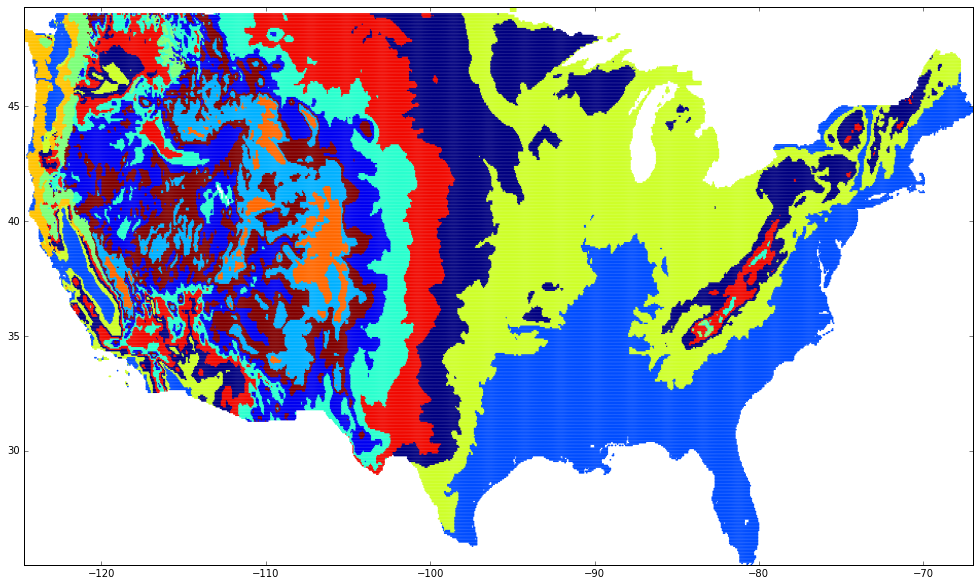

(36, 614, 927)
(1, 614, 927)


KeyboardInterrupt: 

In [118]:
for i in xrange(5, 21):
    lc = Location_Clusterer(n_clusters=i)
    for f, var in zip(files, var_names):
        lc.read_data(folder+f, var)

    lc.transform_data()
    prediction = lc.fit_predict(lc.data2d)

    plot_list_in_2D(lc.coords2d[:,0], lc.coords2d[:,1], prediction)

In [200]:
veg_types = pd.read_table('/Users/Chiao/google-drive/projects/Galvanize/fall-foliage-finder/data/LDAS_veg_lib')\
                                                                                                         ['COMMENT']


(11, 614, 927)
(614, 927)


In [11]:
lc.mask

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]], dtype=bool)

In [170]:
df_cv = pd.DataFrame()
mask = Cv.mask[0]

for i, v_type in enumerate(veg_types):
    df_cv[v_type] = Cv[i].flatten()

In [171]:
df_cv = df_cv[df_cv < 1000000].dropna()